In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
#Load model
model = load_model('model_240_240_MLP_10_64.h5')

#Load 2020 data
df_2020_actual = pd.read_csv("data/2020_WEP.csv",index_col=0, parse_dates=True)
# time_index = pd.date_range(start='1/1/2020 00:00:00', end='3/1/2020 23:30:00', freq="30min")
# df_2020_actual.index = time_index

#Convert to supervised
df_2020_window = df_2020_actual.copy()
std = df_2020_window['WEP ($/MWh)'].std()
mean = df_2020_window['WEP ($/MWh)'].mean()
df_2020_window['WEP ($/MWh)'].loc[df_2020_window['WEP ($/MWh)'] > mean + 3*std] = mean + 3*std
df_2020_window = series_to_supervised(df_2020_window,336,1)
df_2020_window = df_2020_window.rename(columns={"var1(t)": "WEP ($/MWh)"})

1.6655471324920654


Text(0, 0.5, 'WEP ($)')

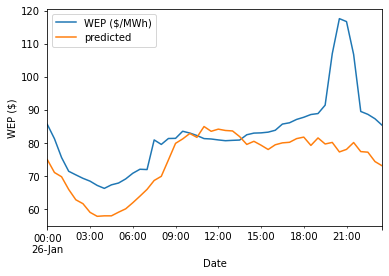

In [4]:
date = '2020-01-16'
days_ahead = 10
predict_start_date = (datetime.strptime(date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
df_2020_WEP_cut = df_2020_window[:date]['WEP ($/MWh)'].reset_index().set_index('index').copy()
df_2020_window_wPredicted = df_2020_window[:date].copy()

start = time.time()
for i in range(days_ahead):
    #Load input date as numpy array
    arr = df_2020_window_wPredicted[(datetime.strptime(date, '%Y-%m-%d') + timedelta(days=i)).strftime('%Y-%m-%d')].to_numpy()

    date_predict = (datetime.strptime(date, '%Y-%m-%d') + timedelta(days=i+1)).strftime('%Y-%m-%d')
    #print (arr.shape)

    #Predict next 48 steps == 1 day
    result = model.predict(arr[0:1,:-1])
    #print (result[0])
    temp=pd.Series(result[0]).to_frame(name='WEP ($/MWh)')

    temp.index=df_2020_window[date_predict].index

    new=pd.concat([df_2020_WEP_cut,temp])

    values = new.values
    data = series_to_supervised(values, 336, 1, False)
    data.index = new.index
    df_2020_window_wPredicted = data.rename(columns={"var1(t)": "WEP ($/MWh)"}).dropna()
    df_2020_WEP_cut=new.copy()
end = time.time()
print(end - start)  

predicted_days = df_2020_WEP_cut[predict_start_date:date_predict]
actual_days = df_2020_actual[predict_start_date:date_predict]['WEP ($/MWh)'].reset_index().set_index('index')

#Plot predicted vs actual
actual_days['predicted']=predicted_days['WEP ($/MWh)']
actual_days[(datetime.strptime(date, '%Y-%m-%d') + timedelta(days=10)).strftime('%Y-%m-%d')].plot()
plt.xlabel("Date")
plt.ylabel("WEP ($)")

WEP ($/MWh)     82.533542
predicted       74.344120
MAE              8.864502
MSE            146.726353
MAPE            10.198592
dtype: float64


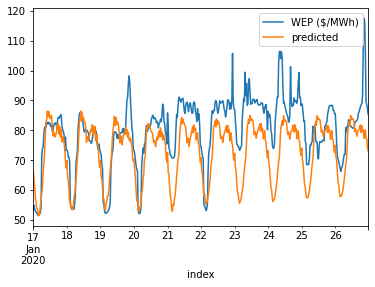

In [5]:
actual_days.plot()
actual_days['MAE']=actual_days['WEP ($/MWh)'] - actual_days['predicted']
actual_days['MAE']=actual_days['MAE'].abs()
actual_days['MSE']=actual_days['MAE']*actual_days['MAE']
actual_days['MAPE']=actual_days['MAE']/actual_days['WEP ($/MWh)']*100
print (actual_days[(datetime.strptime(date, '%Y-%m-%d') + timedelta(days=10)).strftime('%Y-%m-%d')].mean())
actual_days[(datetime.strptime(date, '%Y-%m-%d') + timedelta(days=10)).strftime('%Y-%m-%d')].to_csv("NN_16Feb.csv")